# 移動平均の誤差について
移動平均による予測と実データによる評価

## 前処理(予測まで)

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import matplotlib.dates as mdates

In [48]:
def root_mean_squared_error(y_pred, y_test):
    return mean_squared_error(y_pred, y_test)**(1/2)

In [49]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [50]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [51]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
# df = df.drop("date", axis=1).copy()


In [52]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [53]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [54]:
ma_w3 = df["価格"].iloc[2:]
ma_w5 = df["価格"].rolling(5).apply(ma_weighted, args=(df,), raw=False)
ma_w7 = df["価格"].iloc[6:]


In [55]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
start_test_idx = 9426
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < start_test_idx].copy()
df_test = ma_w5[ma_w5.index >= start_test_idx].copy()


In [56]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [57]:
# 学習データ作成
# data = [4日後予測訓練データ, 5日後予測訓練データ, ..., 10日後予測訓練データ]

# 入力データから予測対象日までの最短日数 = 輸送日数 + [1,2,3,4,5,6,7,...]
span = 10   # 何日分予測するか
n_input = 7 # 何日分入力するか
# move_days = 3 # 輸送日数
data = []
for sp in range(span):

    sp = sp + 1 # 予測日は最低move_days+1日後

    n_train = df_train.shape[0] - (n_input - 1)  - sp

    X_train_idx = [np.arange(n_input) + i for i in range(n_train)]
    y_train_idx = [(n_input - 1)  + sp + i for i in range(n_train)]

    date_train_idx = [i + (n_input - 1) for i in range(n_train)]

    n_test = df_test.shape[0] - (n_input - 1)  - sp
    
    X_test_idx = [np.arange(n_input) + i for i in range(n_test)]
    y_test_idx = [(n_input - 1)  + sp + i for i in range(n_test)]

    date_test_idx = [i + (n_input - 1) for i in range(n_test)]

    X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

    y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

    X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
    y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

    X_train = pd.DataFrame(X_train, columns=np.arange(n_input))
    X_test = pd.DataFrame(X_test, columns=np.arange(n_input))
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)

    date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
    date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

    X_train = pd.concat([X_train, date_train], axis=1)
    X_test = pd.concat([X_test, date_test], axis=1)

    data.append((X_train, X_test, y_train, y_test))

In [58]:
# y_preds = [4日後予測データ, 5日後予測データ, ..., 10日後予測データ]
y_preds = []
for i in range(data.__len__()):
    X_train, X_test, y_train, y_test = data[i][0], data[i][1], data[i][2], data[i][3]

    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = root_mean_squared_error(y_pred, y_test)
    print(score)

    ape = sum(abs((y_test-y_pred)/y_test))
    mape = ape/y_test.shape[0]
    print(mape)

    y_preds.append(y_pred)

86.3660628060243
0.014702976436834556
108.6483106441697
0.024029336856528444
130.8141249833999
0.03227978469602585
152.87335371530077
0.04265687606131471
167.42563249986372
0.04898505031284628
178.33708145843627
0.056432169833098976
187.275739116027
0.06050149909514425
192.52051982586158
0.06181689322490505
198.87448514492291
0.06552261407165835
208.60556557978728
0.06955631357819869


In [59]:
# 予測データ数を揃える
y_preds_min_len = min(list(map(len, y_preds)))
y_preds_fix = []
for p in y_preds:
    y_preds_fix.append(p[:y_preds_min_len])

data_fix = []
for d in data:
    X_train_fix = d[0].iloc[:y_preds_min_len]
    X_test_fix = d[1].iloc[:y_preds_min_len]
    y_train_fix = d[2].iloc[:y_preds_min_len]
    y_test_fix = d[3].iloc[:y_preds_min_len]
    data_fix.append((X_train_fix, X_test_fix, y_train_fix, y_test_fix))

# 移動平均とサイズを合わせるために最初4日分をドロップ
df_for_compare = df["価格"].iloc[4:]

df_c_train = df_for_compare[df_for_compare.index < start_test_idx].copy()
df_c_test = df_for_compare[df_for_compare.index >= start_test_idx].copy()

date_c_train_raw = df.loc[df_c_train.index, ["年", "月", "日", "曜日"]].copy()
date_c_test_raw = df.loc[df_c_test.index, ["年", "月", "日", "曜日"]].copy()

data_c = []
for sp in range(span):

    sp = sp + 1 # 予測日は最低move_days+1日後

    n_c_train = df_c_train.shape[0] - (n_input - 1)  - sp
    
    X_c_train_idx = [np.arange(n_input) + i for i in range(n_c_train)]
    y_c_train_idx = [(n_input - 1) + sp + i for i in range(n_c_train)]

    date_c_train_idx = [i + (n_input - 1) for i in range(n_c_train)]

    n_c_test = df_c_test.shape[0] - (n_input - 1) - sp
    
    X_c_test_idx = [np.arange(n_input) + i for i in range(n_c_test)]
    y_c_test_idx = [(n_input - 1)  + sp + i for i in range(n_c_test)]

    date_c_test_idx = [i + (n_input - 1) for i in range(n_c_test)]

    X_c_train = np.array([df_c_train.iloc[xt_i].values for xt_i in X_c_train_idx])

    y_c_train = np.array([df_c_train.iloc[yt_i] for yt_i in y_c_train_idx])

    X_c_test = np.array([df_c_test.iloc[xt_i].values for xt_i in X_c_test_idx])
    y_c_test = np.array([df_c_test.iloc[yt_i] for yt_i in y_c_test_idx])

    X_c_train = pd.DataFrame(X_c_train, columns=np.arange(n_input))
    X_c_test = pd.DataFrame(X_c_test, columns=np.arange(n_input))
    y_c_train = pd.Series(y_c_train)
    y_c_test = pd.Series(y_c_test)

    date_c_train = date_c_train_raw.iloc[date_c_train_idx].reset_index(drop=True)
    date_c_test = date_c_test_raw.iloc[date_c_test_idx].reset_index(drop=True)

    X_c_train = pd.concat([X_c_train, date_c_train], axis=1)
    X_c_test = pd.concat([X_c_test, date_c_test], axis=1)

    data_c.append((X_c_train, X_c_test, y_c_train, y_c_test))

In [60]:
y_c_test = [d[3] for d in data_c]

In [61]:
# 元データに対する移動平均予測の結果
for ma, raw in zip(y_preds, y_c_test):
    print(root_mean_squared_error(ma, raw))

193.42105778835023
204.2845733239545
217.27478462314653
235.49586992785893
241.79046547632137
245.37001766544415
250.54073353409234
253.94810250083125
257.3780695652578
261.523795869823


In [62]:
y_preds_ma = y_preds.copy()

In [63]:
df_raw = pd.read_csv("../data/kk.csv")
# 全体のみを利用(産地名NaN)
is_nan = [df_raw["産地名"][i] is df_raw["産地名"][0] for i in range(df_raw.shape[0])]
df = df_raw[is_nan].copy()
del_columns = ["産地名", "産地コード", "品目名", "品目コード", "対前日比（数量）", "対前日比（価格）"]
df = df.drop(del_columns, axis=1).copy()


In [64]:
# 曜日の処理
dow = ["月", "火", "水", "木", "金", "土", "日"]
df["曜日"] = [dow.index(dw) for dw in df["曜日"]]


In [65]:
# 日にちの処理
# timestamp型 → timedelta
# date_columns = ["年", "月", "日"]
date = [str(df["年"].iloc[i])+"-"+str(df["月"].iloc[i])+"-" +
        str(df["日"].iloc[i]) for i in range(df.shape[0])]
df["date"] = pd.to_datetime(date)
# df = df.drop(date_columns, axis=1).copy()
df["days"] = [(date - df["date"][0]).days for date in df["date"]]
# df = df.drop("date", axis=1).copy()


In [66]:
# 特異日 (天皇即位)
outlier = df[df["価格"].max() == df["価格"]].index 
# df = df.drop(outlier, axis=0).copy()

In [67]:
# 数量で重み付け
def ma_weighted(price, df):
    """
    Args:
        price (df.rolling): df.rolling.apply()を想定した価格列
        df: 重み列を取るための元df
    return:
        ma_w = 数量加重移動平均
    """

    df_price = df.loc[price.index, '価格']
    df_num = df.loc[price.index, '数量']
    
    ma_w = 0
    for p, n in zip(df_price, df_num):
        ma_w += n * p/df_num.sum()

    return ma_w


In [68]:
ma_w3 = df["価格"].iloc[2:]
ma_w5 = df["価格"].iloc[4:]
ma_w7 = df["価格"].iloc[6:]


In [69]:
# train-test-split
# 7年分をtrain，3年分をtest(index 9426以上)
start_test_idx = 9426
ma_w5 = ma_w5.dropna()
df_train = ma_w5[ma_w5.index < start_test_idx].copy()
df_test = ma_w5[ma_w5.index >= start_test_idx].copy()


In [70]:
date_train_raw = df.loc[df_train.index, ["年", "月", "日", "曜日"]].copy()
date_test_raw = df.loc[df_test.index, ["年", "月", "日", "曜日"]].copy()

In [71]:
# 学習データ作成
# data = [4日後予測訓練データ, 5日後予測訓練データ, ..., 10日後予測訓練データ]

# 入力データから予測対象日までの最短日数 = 輸送日数 + [1,2,3,4,5,6,7,...]
span = 10   # 何日分予測するか
n_input = 7 # 何日分入力するか
# move_days = 3 # 輸送日数
data = []
for sp in range(span):

    sp = sp + 1 # 予測日は最低move_days+1日後

    n_train = df_train.shape[0] - (n_input - 1)  - sp

    X_train_idx = [np.arange(n_input) + i for i in range(n_train)]
    y_train_idx = [(n_input - 1)  + sp + i for i in range(n_train)]

    date_train_idx = [i + (n_input - 1) for i in range(n_train)]

    n_test = df_test.shape[0] - (n_input - 1)  - sp
    
    X_test_idx = [np.arange(n_input) + i for i in range(n_test)]
    y_test_idx = [(n_input - 1)  + sp + i for i in range(n_test)]

    date_test_idx = [i + (n_input - 1) for i in range(n_test)]

    X_train = np.array([df_train.iloc[xt_i].values for xt_i in X_train_idx])

    y_train = np.array([df_train.iloc[yt_i] for yt_i in y_train_idx])

    X_test = np.array([df_test.iloc[xt_i].values for xt_i in X_test_idx])
    y_test = np.array([df_test.iloc[yt_i] for yt_i in y_test_idx])

    X_train = pd.DataFrame(X_train, columns=np.arange(n_input))
    X_test = pd.DataFrame(X_test, columns=np.arange(n_input))
    y_train = pd.Series(y_train)
    y_test = pd.Series(y_test)

    date_train = date_train_raw.iloc[date_train_idx].reset_index(drop=True)
    date_test = date_test_raw.iloc[date_test_idx].reset_index(drop=True)

    X_train = pd.concat([X_train, date_train], axis=1)
    X_test = pd.concat([X_test, date_test], axis=1)

    data.append((X_train, X_test, y_train, y_test))

In [72]:
# y_preds = [4日後予測データ, 5日後予測データ, ..., 10日後予測データ]
y_preds = []
for i in range(data.__len__()):
    X_train, X_test, y_train, y_test = data[i][0], data[i][1], data[i][2], data[i][3]

    model = lgb.LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = root_mean_squared_error(y_pred, y_test)
    print(score)

    ape = sum(abs((y_test-y_pred)/y_test))
    mape = ape/y_test.shape[0]
    print(mape)

    y_preds.append(y_pred)

201.19805032654395
0.04339122912454649
217.75681095145623
0.04994314474491884
222.89726638278697
0.05546964988928581
243.7578133240157
0.0608175532611717
246.3776624760672
0.06536235705257999
255.75490025549578
0.06989128820165379
260.8637338149849
0.07252330845673073
262.37631662265665
0.0747145959184279
260.1769995055441
0.07687275354764968
256.2103246419697
0.0782405607825423


In [104]:
date = df[df["年"] == 2020]["date"]

In [105]:
y_test_plot = y_c_test[6][249:249+264]
y_pred_ma_plot = y_preds_ma[6][249:249+264]
y_pred_plot = y_preds[6][249:249+264]

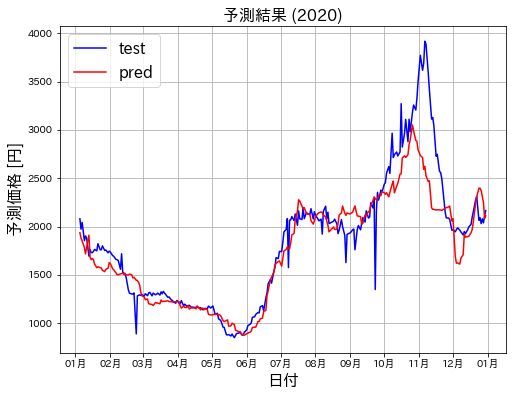

In [111]:
fig, ax = plt.subplots()
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(6)

ax.plot(date, y_test_plot, "b", label="test")
ax.plot(date, y_pred_ma_plot, "r", label="pred")
# ax.plot(date, y_pred_plot, "g", label="pred_raw")
ax.legend(fontsize=16)
ax.set_xlabel("日付", fontsize=16)
ax.set_ylabel("予測価格 [円]", fontsize=16)
ax.set_title("予測結果 (2020)", fontsize=16)

# Formatterでx軸の日付ラベルを月・日に設定
xfmt = mdates.DateFormatter("%m月")
xloc = mdates.MonthLocator()

ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(xfmt)



In [35]:
week_days = np.arange(50)
start_days = np.arange(5) * 50

In [36]:
plot_list = np.array([week_days + sd for sd in start_days])

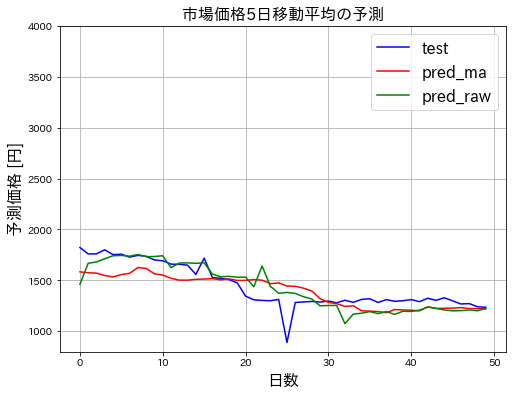

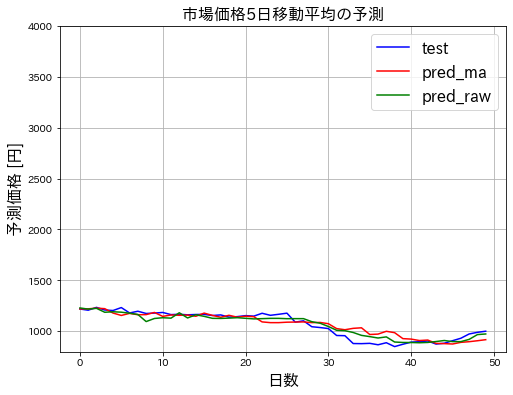

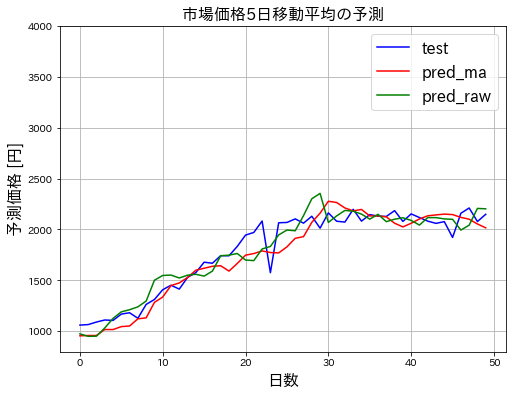

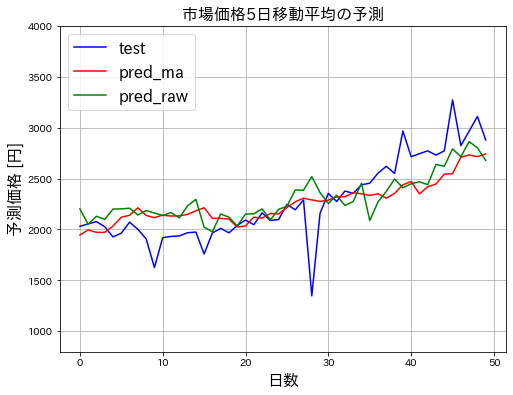

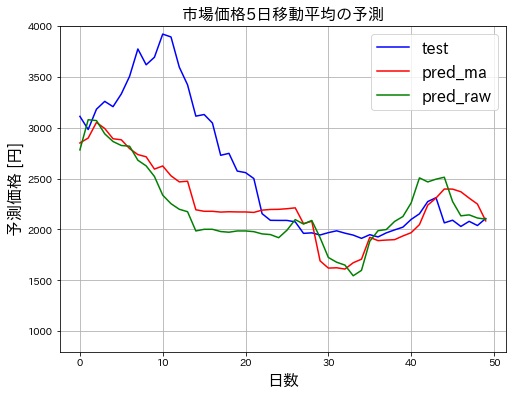

In [37]:
for pl in plot_list:
    fig, ax = plt.subplots()
    ax.grid()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    ax.plot(np.arange(y_c_test.iloc[pl].shape[0]), y_c_test.iloc[pl], "b", label="test")
    ax.plot(np.arange(y_pred_ma[pl].shape[0]), y_pred_ma[pl], "r", label="pred_ma")
    ax.plot(np.arange(y_pred[pl].shape[0]), y_pred[pl], "g", label="pred_raw")
    ax.legend(fontsize=16)
    ax.set_xlabel("日数", fontsize=16)
    ax.set_ylabel("予測価格 [円]", fontsize=16)
    ax.set_title("市場価格5日移動平均の予測", fontsize=16)

    ax.set_ylim([800,4000])